In [1]:
## add paths so that caffe and python layer can be loaded in
import sys
sys.path.append('caffe/python/')
sys.path.append('src/')

from utils import decode_labels

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import caffe
import numpy as np
import subprocess

In [3]:
caffe.set_mode_cpu()

In [4]:
img_path = 'misc/2007_000129.jpg'
caffemodel_file = 'model/gdn.caffemodel'
prototxt_file = 'src/current.prototxt'

In [5]:
## loading weights
W0 = np.load('model/w0_500.npy')
W1 = np.load('model/w1_500.npy')

img_orig = Image.open(img_path)
x_orig, y_orig = img_orig.size

## the model has been trained on images with height/width at maximum 500
x_new = np.minimum(x_orig, 500)
y_new = np.minimum(y_orig, 500)

img_orig_arr = np.array(img_orig.resize((x_new, y_new), Image.NEAREST), dtype = np.float32)
img_orig_arr = img_orig_arr[:, :, ::-1] - np.array((104.00698793,116.66876762,122.67891434))
img_orig_arr = img_orig_arr.transpose((2, 0, 1))           

x_dim, y_dim = img_orig_arr.shape[1:3]

## change the prototxt file accordingly to the image size
subprocess.call(['src/proto.sh',
                 str(x_dim), str(y_dim)])

net = None
net = caffe.Net(prototxt_file, caffemodel_file, caffe.TEST)

x_small_dim, y_small_dim = net.blobs['fc8_voc12'].data.shape[2:]
net.blobs['data'].data[...] = img_orig_arr
net.params['gdn'][0].data.flat = W0[:x_small_dim, :x_dim].flat
net.params['gdn'][1].data.flat = W1[:y_small_dim, :y_dim].flat

upscore = net.forward()['upscore']

In [6]:
outputs = decode_labels(upscore.argmax(axis=1))

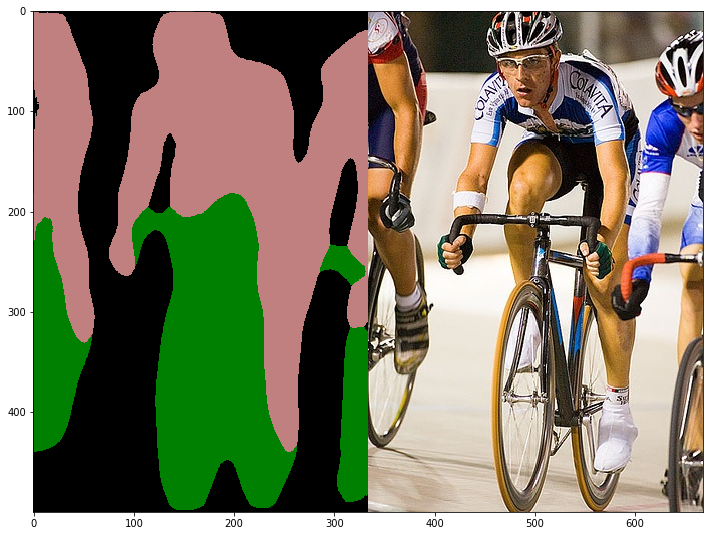

In [7]:
plt.figure(figsize = (12, 10))
plt.imshow(np.concatenate([outputs[0], img_orig], axis=1));